In [7]:
from torch.utils.data import Dataset
import torch


class random_pattern(Dataset):
    def __init__(self, size=None, pattern1=None, pattern2=None):
        if pattern1 == None and pattern2 == None:
            if size == None:
                raise ValueError("Whether patterns or the size must be given")
            pattern1 = (torch.rand(size) > 0.5).type(torch.int8)
            pattern2 = (torch.rand(size) > 0.5).type(torch.int8)
        self.pats = [pattern1, pattern2]
            
        

    def __len__(self) -> int:
        return len(self.pats)

    def __getitem__(self, index):
        return self.pats[index % 2].squeeze(), index % 2
        

from pymonntorch import NeuronGroup, SynapseGroup, NeuronDimension, EventRecorder
from conex import Neocortex, InputLayer, Synapsis, prioritize_behaviors, CorticalColumn
from conex.helpers.transforms.encoders import Poisson
from conex.helpers.transforms.misc import SqueezeTransform
from conex.nn.priority import ALL_PRIORITIES
from conex.behaviors.synapses import SynapseInit, WeightInitializer, LateralDendriticInput, SimpleDendriticInput, WeightNormalization
from conex.behaviors.synapses.learning import SimpleSTDP

from conex.behaviors.neurons.axon import NeuronAxon
from conex.behaviors.neurons.specs import SpikeTrace
from conex.behaviors.neurons.dendrite import SimpleDendriteStructure

from neuralBehaviors import *
from metrics import draw_weights


from torch.utils.data import DataLoader

SIZE = 10
TIME = 30
NORM = 10
dataset = random_pattern(size=SIZE)

dl = DataLoader(dataset=dataset, batch_size=16)

##################################################
# initializing neocortex
################################################## 
net = Neocortex(dt=1)
##################################################


##################################################
# input layer
##################################################
input_layer = InputLayer(
    net=net,
    input_dataloader=dl,
    sensory_data_dim=1,
    sensory_size=SIZE,
    sensory_trace=2.7,
    instance_duration=TIME,
    output_ports={"data_out": (None,[("sensory_pop", {})])},
    sensory_user_defined={500: EventRecorder(variables=['spikes']), ALL_PRIORITIES['NeuronAxon']: NeuronAxon()})

out_ng = NeuronGroup(net=net, size=2, tag='out', behavior={**prioritize_behaviors(
    [
        NeuronAxon(),
        SpikeTrace(tau_s=0.9),
        SimpleDendriteStructure(),
    ]),
    250: InputBehavior(),
    260: LIFBehavior(R=300, adaptive=False),
    500: EventRecorder(variables=['spikes'])
    })
synapsis_input_out = SynapseGroup(net=net, src=input_layer.sensory_pop, dst=out_ng, behavior=
                                    prioritize_behaviors(
                                      [
                                        SynapseInit(), 
                                        SimpleDendriticInput(),
                                        WeightInitializer(mode='random', weight_shape=(10, 2), scale=1 + NORM // SIZE), 
                                        WeightNormalization(norm=NORM),
                                        SimpleSTDP(a_plus=1, a_minus=1),
                                      ]
                                    ), tag="Proximal")

# synapsis_out_lateral = SynapseGroup(net=net, src=out_ng, dst=out_ng, behavior=
#                                     prioritize_behaviors(
#                                       [
#                                           SynapseInit(),
#                                           WeightInitializer(mode='random', weight_shape=(1, 1, 3, 3, 3)),
#                                           LateralDendriticInput(),
#                                       ]
#                                     ), tag="Proximal")


net.initialize()
oldW = synapsis_input_out.weights.clone()
net.simulate_iterations(50)
newW = synapsis_input_out.weights.clone()

print(f"Diff W = \n{newW - oldW}")

print(f"input layer spikes: {input_layer.sensory_pop['spikes'][0].shape}")
print(f"out layer spikes: {out_ng['spikes'][0].shape[0] if out_ng['spikes'] else 0}")

print(f"Weights:\n{synapsis_input_out.weights}")



Network['Neocortex'](Neurons: tensor(12)|2 groups, Synapses: tensor(20)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['Sensory', 'NeuronGroup', 'ng'](10){340:SensorySetter()360:SpikeTrace(tau_s=2.7,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)500:EventRecorder(variables=['spikes'],gap_width=0,max_length=None,auto_annotate=True,tag=None,)}
NeuronGroup['out', 'NeuronGroup', 'ng'](2){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)250:InputBehavior(func=None,verbose=False,func_args={},)260:LIFBehavior(func=exp,adaptive=False,Urest=-70,Uthresh=-50,Ureset=-75,Upeak=30.0,R=300,leak=True,tau_m=20,Tref=0,a=0.0,b=60,tau_w=30.0,variation=0.1,func_kwargs={},)360:SpikeTrace(tau_s=0.9,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)500:EventRecorder(variables=['spikes'],gap_width=0

tensor([[1.7777, 1.7301],
        [1.9355, 0.8042],
        [0.8128, 1.5539],
        [0.4625, 1.5084],
        [0.1867, 0.1987],
        [1.3098, 0.5406],
        [0.4252, 0.9805],
        [0.2070, 1.9215],
        [0.5319, 0.0572],
        [0.4108, 0.9610]])
tensor([ 8.0600, 10.2563])
tensor([[1.9193e+00, 1.9193e+00],
        [3.5330e-07, 1.1537e-07],
        [1.9193e+00, 1.9193e+00],
        [1.2323e+00, 1.2323e+00],
        [3.4076e-08, 2.8508e-08],
        [1.2323e+00, 1.2323e+00],
        [1.2323e+00, 1.2323e+00],
        [3.7778e-08, 2.7563e-07],
        [1.2323e+00, 1.2323e+00],
        [1.2323e+00, 1.2323e+00]])
tensor([10.0000, 10.0000])


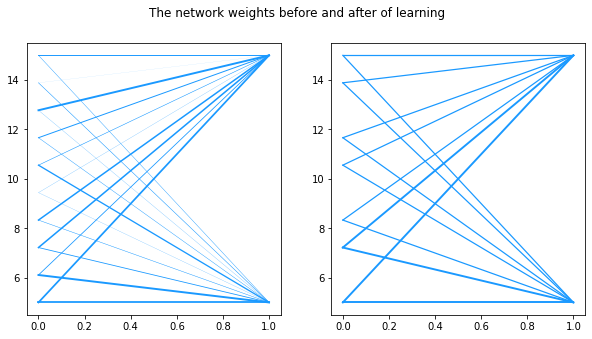

In [8]:
import matplotlib.pyplot as plt
print(f"Patterns:\n")
print(oldW)
print(oldW.sum(0))
print(newW)
print(newW.sum(0))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
draw_weights(weights=oldW, ax=ax[0], scale_w=1)
draw_weights(weights=newW, ax=ax[1], scale_w=1)
plt.suptitle("The network weights before and after of learning")
plt.show()
